Regional Performance Test (Default Rate)
H₀: Default rate is independent of region rating.
H₁: Default rate depends on region rating.
Chi-square: Statistic=1067.19, p=0.0000, df=2
Conclusion: Reject H₀; default rate depends on region rating.

Default Proportions by Region Rating:
TARGET                       0         1
REGION_RATING_CLIENT                    
1                     0.951797  0.048203
2                     0.921109  0.078891
3                     0.888972  0.111028


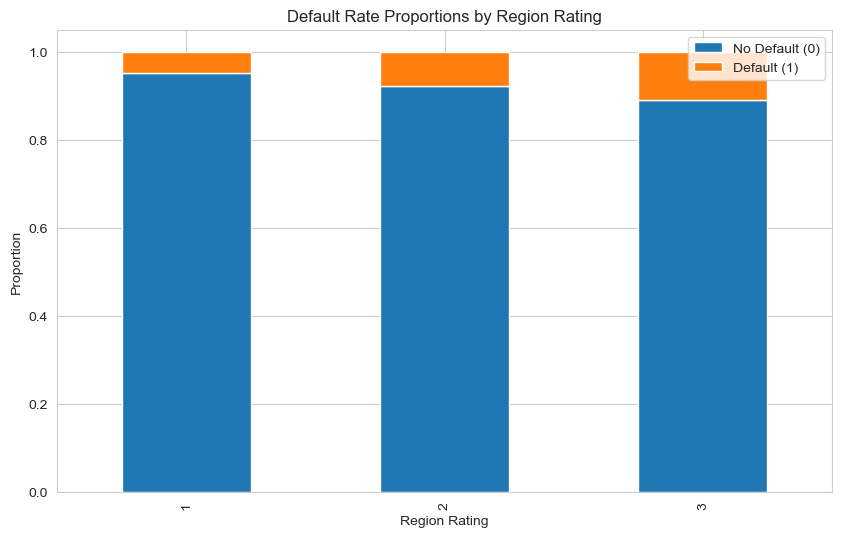

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Load dataset
df = pd.read_csv('application_train.csv')
df['REGION_RATING_CLIENT'] = df['REGION_RATING_CLIENT'].fillna(df['REGION_RATING_CLIENT'].mode()[0])

# Create contingency table
contingency_table = pd.crosstab(df['REGION_RATING_CLIENT'], df['TARGET'])

# Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
alpha = 0.05
print("Regional Performance Test (Default Rate)")
print("H₀: Default rate is independent of region rating.")
print("H₁: Default rate depends on region rating.")
print(f"Chi-square: Statistic={chi2:.2f}, p={p:.4f}, df={dof}")
print("Conclusion:", "Reject H₀; default rate depends on region rating." if p < alpha else "Fail to reject H₀.")

# Proportion analysis
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)
print("\nDefault Proportions by Region Rating:")
print(proportions)

# Visualization
proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Default Rate Proportions by Region Rating')
plt.xlabel('Region Rating')
plt.ylabel('Proportion')
plt.legend(['No Default (0)', 'Default (1)'])
plt.show()

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime

# Load and clean data
df = pd.read_csv('application_train.csv')
df['REGION_RATING_CLIENT'] = df['REGION_RATING_CLIENT'].fillna(df['REGION_RATING_CLIENT'].mode()[0])
df['TARGET'] = pd.to_numeric(df['TARGET'], errors='coerce')

# === Assumption Checks ===
print("\n=== Logistic Regression Assumption Checks ===")
assumptions_met = True

# 1. Binary Outcome Check
unique_target = df['TARGET'].dropna().unique()
if set(unique_target).issubset({0, 1}):
    print("✅ TARGET is binary.")
else:
    print("❌ TARGET is not binary.")
    assumptions_met = False

# 2. Missing Values Check
missing_X = df['REGION_RATING_CLIENT'].isnull().sum()
missing_y = df['TARGET'].isnull().sum()
if missing_X == 0 and missing_y == 0:
    print("✅ No missing values in REGION_RATING_CLIENT or TARGET.")
else:
    print(f"⚠️ Missing values — REGION_RATING_CLIENT: {missing_X}, TARGET: {missing_y}")
    assumptions_met = False

# 3. One-hot encode REGION_RATING_CLIENT (drop first as baseline)
X_raw = pd.get_dummies(df['REGION_RATING_CLIENT'], prefix='REGION', drop_first=True)
X_raw = sm.add_constant(X_raw)
X_clean = X_raw.apply(pd.to_numeric, errors='coerce')
y_clean = pd.to_numeric(df['TARGET'], errors='coerce')

# 4. Align and drop NaNs
valid_index = X_clean.dropna().index.intersection(y_clean.dropna().index)
X_final = X_clean.loc[valid_index].astype(float)
y_final = y_clean.loc[valid_index].astype(float)

# 5. Multicollinearity Check (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_final.columns
vif_data["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(X_final.shape[1])]
print("\nVariance Inflation Factor (VIF):")
print(vif_data)

if vif_data["VIF"].max() < 5:
    print("✅ No severe multicollinearity detected.")
else:
    print("⚠️ High VIF values detected. Consider dropping or combining correlated features.")
    assumptions_met = False

# 6. Sample Size Check
min_class_count = y_final.value_counts().min()
num_predictors = X_final.shape[1] - 1  # exclude constant
if min_class_count >= 10 * num_predictors:
    print(f"✅ Sample size is sufficient: {min_class_count} cases in minority class for {num_predictors} predictors.")
else:
    print(f"❌ Sample size may be insufficient: {min_class_count} cases for {num_predictors} predictors.")
    assumptions_met = False

# 7. Linearity of Log-Odds (Placeholder)
print("ℹ️ Linearity of log-odds not tested here. Recommended for continuous predictors using Box-Tidwell.")

# Final decision
if assumptions_met:
    print("\n✅ All key assumptions are met. Proceeding with logistic regression...\n")
else:
    print("\n❌ One or more assumptions not met. Review before proceeding with logistic regression.\n")

# === Fit Logistic Regression ===
model = sm.Logit(y_final, X_final).fit()

# === Detect true baseline category ===
all_categories = sorted(df['REGION_RATING_CLIENT'].dropna().unique())
dummy_categories = [col.replace('REGION_', '') for col in X_final.columns if col.startswith('REGION_')]
baseline_region = list(set(map(str, all_categories)) - set(dummy_categories))[0]

# === Logistic Regression Summary ===
print("\n=== Logistic Regression for Loan Default Risk ===")
print(model.summary())

# === Business-Friendly Interpretations ===
print("\n=== Business-Friendly Interpretations ===")
intercept = model.params['const']
baseline_odds = np.exp(intercept)
print(f"Baseline (REGION_{baseline_region}): log-odds = {intercept:.4f}, odds of default = {baseline_odds:.4f}")

# Model equation
equation_terms = [f"{model.params[col]:+.4f}·{col}" for col in X_final.columns[1:]]
equation = f"log(p / (1 - p)) = {intercept:.4f} " + " ".join(equation_terms)
print(f"\nModel Equation:\n{equation}")

for col in X_final.columns[1:]:
    coef = model.params[col]
    odds_ratio = np.exp(coef)
    direction = "increases" if coef > 0 else "reduces"
    magnitude = (odds_ratio - 1) * 100 if coef > 0 else (1 - odds_ratio) * 100
    region = col.split('_')[-1]
    print(f"\nREGION_{region} vs REGION_{baseline_region}:")
    print(f"- Coefficient: {coef:.4f}")
    print(f"- Odds Ratio: {odds_ratio:.3f}")
    print(f"- Interpretation: REGION_{region} {direction} odds of default by {abs(magnitude):.1f}% compared to REGION_{baseline_region}.")
    print(f"- Strategy: {'Apply caution' if coef > 0 else 'Prioritize'} REGION_{region} applicants in approval and pricing.")

# ============================================
# 1. Default Proportions Dataset
# ============================================
contingency_table = pd.crosstab(df['REGION_RATING_CLIENT'], df['TARGET'])
default_props_df = (
    contingency_table
    .div(contingency_table.sum(axis=1), axis=0)[1]
    .reset_index()
    .rename(columns={1: 'Default %'})
)
default_props_df['Default %'] = (default_props_df['Default %'] * 100).round(2)

print("\n=== Default Proportions Dataset ===")
print(default_props_df)

# ============================================
# 2. Logistic Regression Summary Dataset
# ============================================
logit_summary_rows = [{
    'Region': f"REGION_{baseline_region}",
    'Coefficient': None,
    'Odds Ratio': None,
    'Change vs Baseline': 'Baseline',
    'Baseline Odds of Default': round(baseline_odds, 4)
}]

for col in X_final.columns[1:]:
    region = col.split('_')[-1]
    coef = model.params[col]
    odds_ratio = np.exp(coef)
    pct_change = (odds_ratio - 1) * 100
    logit_summary_rows.append({
        'Region': f"REGION_{region}",
        'Coefficient': round(coef, 4),
        'Odds Ratio': round(odds_ratio, 3),
        'Change vs Baseline': f"{pct_change:.1f}%",
        'Baseline Odds of Default': None
    })

logit_summary_df = pd.DataFrame(logit_summary_rows)

print("\n=== Logistic Regression Summary Dataset ===")
print(logit_summary_df)

# ============================================
# Optional: Export for Power BI
# ============================================
default_props_df.to_csv("results/default_proportions_region_performance.csv", index=False)
logit_summary_df.to_csv("results/logistic_regression_summary_region_performance.csv", index=False)



=== Logistic Regression Assumption Checks ===
✅ TARGET is binary.
✅ No missing values in REGION_RATING_CLIENT or TARGET.

Variance Inflation Factor (VIF):
    Feature       VIF
0     const  9.550921
1  REGION_2  2.107990
2  REGION_3  2.107990
⚠️ High VIF values detected. Consider dropping or combining correlated features.
✅ Sample size is sufficient: 24825 cases in minority class for 2 predictors.
ℹ️ Linearity of log-odds not tested here. Recommended for continuous predictors using Box-Tidwell.

❌ One or more assumptions not met. Review before proceeding with logistic regression.

Optimization terminated successfully.
         Current function value: 0.278788
         Iterations 7

=== Logistic Regression for Loan Default Risk ===
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               307511
Model:                          Logit   Df Residuals:                   307508
Method:              

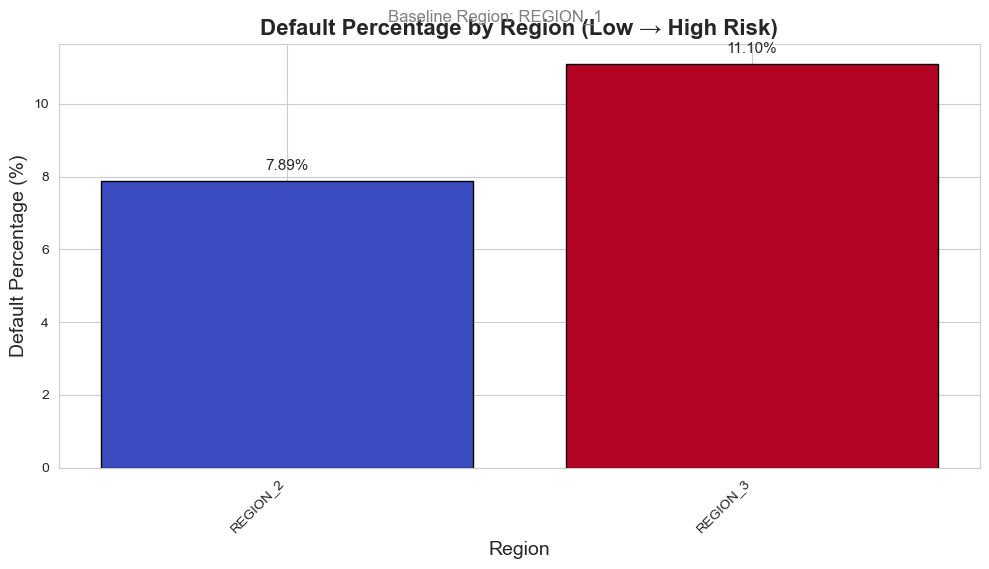

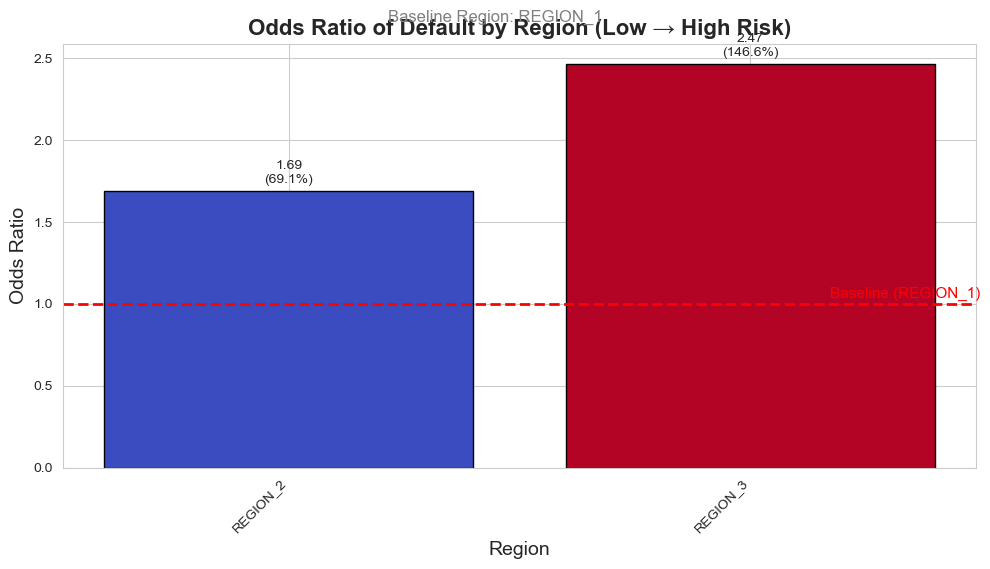

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize
import os

# Ensure output folder exists
os.makedirs("results", exist_ok=True)

# ==============================
# 1. Determine common order by Odds Ratio
# ==============================
# Drop NaN for odds ratio and sort ascending (low risk → high risk)
odds_sorted = (
    logit_summary_df
    .dropna(subset=['Odds Ratio'])
    .sort_values('Odds Ratio', ascending=True)
)
region_order = odds_sorted['Region'].tolist()

# Reorder default_props_df to match
default_props_ordered = default_props_df.copy()
default_props_ordered['Region'] = 'REGION_' + default_props_ordered['REGION_RATING_CLIENT'].astype(str)
default_props_ordered = default_props_ordered.set_index('Region').loc[region_order].reset_index()

odds_ratio_ordered = odds_sorted.copy()

# ==============================
# 2. Default Percentage Chart
# ==============================
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

norm_def = Normalize(vmin=default_props_ordered['Default %'].min(),
                     vmax=default_props_ordered['Default %'].max())
colors_def = cm.coolwarm(norm_def(default_props_ordered['Default %']))

bars = plt.bar(default_props_ordered['Region'],
               default_props_ordered['Default %'],
               color=colors_def, edgecolor='black')

# Highlight baseline
for bar, label in zip(bars, default_props_ordered['Region']):
    if label == f"REGION_{baseline_region}":
        bar.set_linewidth(2.5)
        bar.set_edgecolor('black')
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 "Baseline", ha='center', fontsize=10, fontweight='bold', color='black')

plt.title("Default Percentage by Region (Low → High Risk)", fontsize=16, weight='bold')
plt.suptitle(f"Baseline Region: REGION_{baseline_region}", fontsize=12, color='gray', y=0.94)
plt.xlabel("Region", fontsize=14)
plt.ylabel("Default Percentage (%)", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.3,
             f"{height:.2f}%", ha='center', fontsize=11)

plt.tight_layout()
plt.savefig("results/region_default_percentage_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()

# ==============================
# 3. Odds Ratio Chart
# ==============================
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

norm_or = Normalize(vmin=odds_ratio_ordered['Odds Ratio'].min(),
                    vmax=odds_ratio_ordered['Odds Ratio'].max())
colors_or = cm.coolwarm(norm_or(odds_ratio_ordered['Odds Ratio']))

bars = plt.bar(odds_ratio_ordered['Region'],
               odds_ratio_ordered['Odds Ratio'],
               color=colors_or, edgecolor='black')

# Baseline line + label
plt.axhline(1, color='red', linestyle='--', linewidth=2)
plt.text(len(odds_ratio_ordered)-0.5, 1.02,
         f"Baseline (REGION_{baseline_region})",
         color='red', fontsize=11, va='bottom', ha='right')

plt.title("Odds Ratio of Default by Region (Low → High Risk)", fontsize=16, weight='bold')
plt.suptitle(f"Baseline Region: REGION_{baseline_region}", fontsize=12, color='gray', y=0.94)
plt.xlabel("Region", fontsize=14)
plt.ylabel("Odds Ratio", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Annotate bars
for bar, change in zip(bars, odds_ratio_ordered['Change vs Baseline']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05,
             f"{height:.2f}\n({change})", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("results/region_odds_ratio_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()



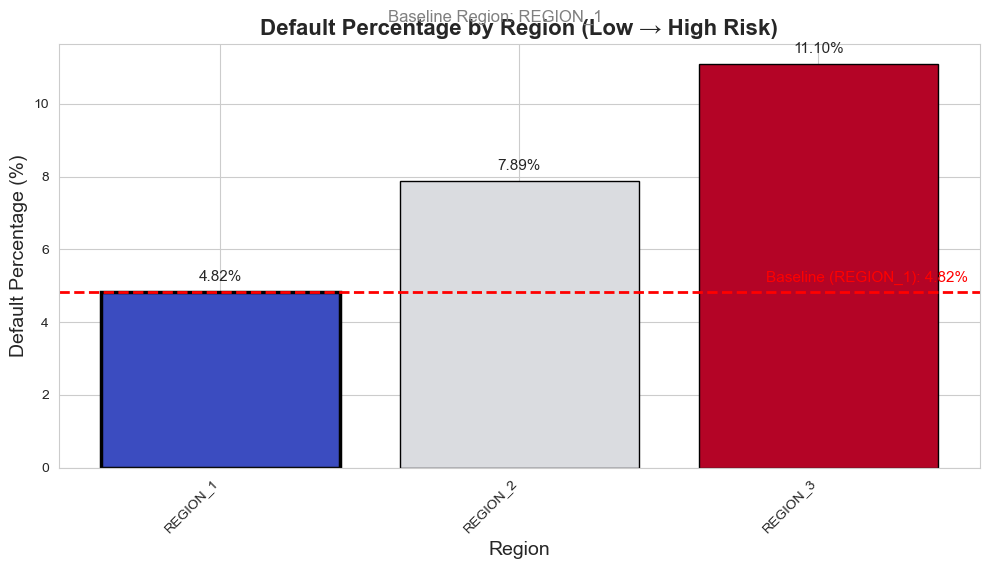

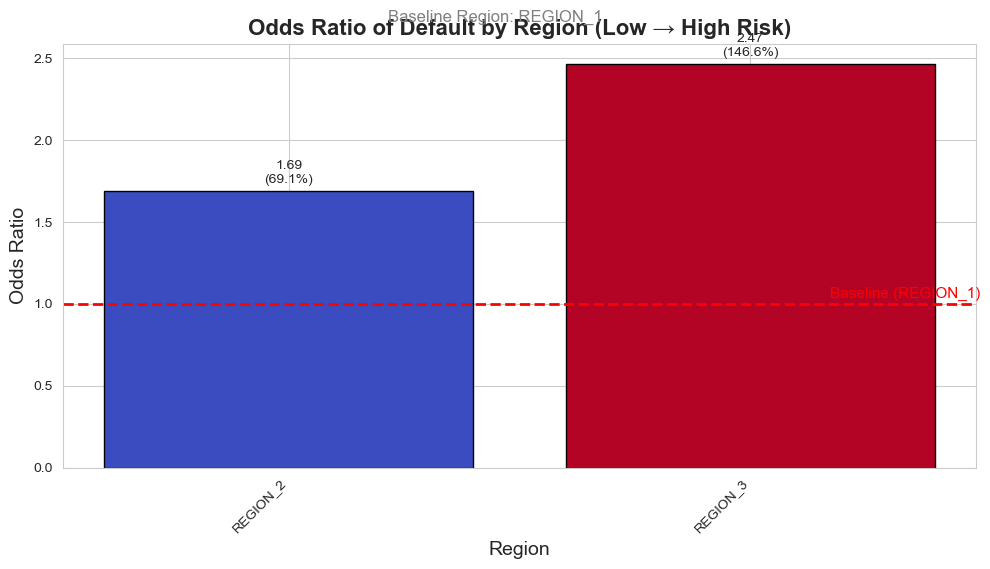

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize
import os

# Ensure output folder exists
os.makedirs("results", exist_ok=True)

# ==============================
# 1. Determine common order by Odds Ratio (low → high risk)
# ==============================
odds_sorted = (
    logit_summary_df
    .dropna(subset=['Odds Ratio'])
    .sort_values('Odds Ratio', ascending=True)
)
region_order = odds_sorted['Region'].tolist()

# Ensure baseline is in the order list
baseline_region_label = f"REGION_{baseline_region}"
if baseline_region_label not in region_order:
    region_order = [baseline_region_label] + region_order

# Reorder default_props_df to match
default_props_ordered = default_props_df.copy()
default_props_ordered['Region'] = 'REGION_' + default_props_ordered['REGION_RATING_CLIENT'].astype(str)
default_props_ordered = default_props_ordered.set_index('Region').loc[region_order].reset_index()

odds_ratio_ordered = odds_sorted.copy()

# ==============================
# 2. Default Percentage Chart (with baseline dashed line)
# ==============================
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

norm_def = Normalize(vmin=default_props_ordered['Default %'].min(),
                     vmax=default_props_ordered['Default %'].max())
colors_def = cm.coolwarm(norm_def(default_props_ordered['Default %']))

bars = plt.bar(default_props_ordered['Region'],
               default_props_ordered['Default %'],
               color=colors_def, edgecolor='black')

# Safely get baseline default percentage
mask = default_props_ordered['Region'] == baseline_region_label
if mask.any():
    baseline_value = default_props_ordered.loc[mask, 'Default %'].iloc[0]
    # Draw baseline dashed line + label
    plt.axhline(baseline_value, color='red', linestyle='--', linewidth=2)
    plt.text(len(default_props_ordered)-0.5, baseline_value + 0.2,
             f"Baseline ({baseline_region_label}): {baseline_value:.2f}%",
             color='red', fontsize=11, va='bottom', ha='right')

# Highlight baseline bar
for bar, label in zip(bars, default_props_ordered['Region']):
    if label == baseline_region_label:
        bar.set_linewidth(2.5)
        bar.set_edgecolor('black')

# Titles & labels
plt.title("Default Percentage by Region (Low → High Risk)", fontsize=16, weight='bold')
plt.suptitle(f"Baseline Region: {baseline_region_label}", fontsize=12, color='gray', y=0.94)
plt.xlabel("Region", fontsize=14)
plt.ylabel("Default Percentage (%)", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Annotate bars
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.3, f"{h:.2f}%", ha='center', fontsize=11)

plt.tight_layout()
plt.savefig("results/region_default_percentage_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()

# ==============================
# 3. Odds Ratio Chart (with baseline dashed line at 1.0)
# ==============================
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

norm_or = Normalize(vmin=odds_ratio_ordered['Odds Ratio'].min(),
                    vmax=odds_ratio_ordered['Odds Ratio'].max())
colors_or = cm.coolwarm(norm_or(odds_ratio_ordered['Odds Ratio']))

bars = plt.bar(odds_ratio_ordered['Region'],
               odds_ratio_ordered['Odds Ratio'],
               color=colors_or, edgecolor='black')

# Baseline line + label
plt.axhline(1, color='red', linestyle='--', linewidth=2)
plt.text(len(odds_ratio_ordered)-0.5, 1.02,
         f"Baseline ({baseline_region_label})",
         color='red', fontsize=11, va='bottom', ha='right')

plt.title("Odds Ratio of Default by Region (Low → High Risk)", fontsize=16, weight='bold')
plt.suptitle(f"Baseline Region: {baseline_region_label}", fontsize=12, color='gray', y=0.94)
plt.xlabel("Region", fontsize=14)
plt.ylabel("Odds Ratio", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Annotate bars
for bar, change in zip(bars, odds_ratio_ordered['Change vs Baseline']):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.05,
             f"{h:.2f}\n({change})", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("results/region_odds_ratio_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()
